In [32]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
#get data
file_path = 'dataset.jsonl'
df = pd.read_json(file_path, lines=True)


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
text     0
label    0
dtype: int64



Class distribution:
label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


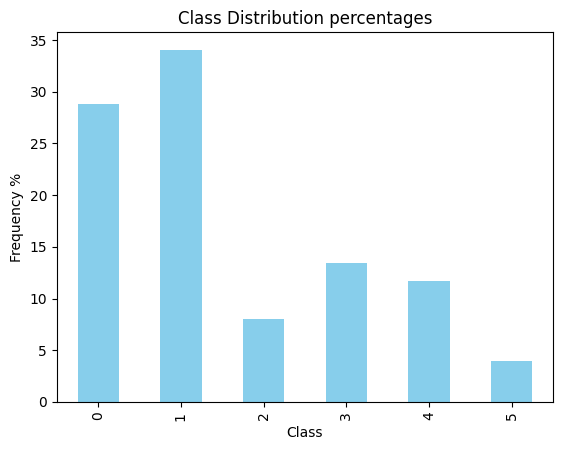

In [9]:
# Class distribution
class_distribution = df['label'].value_counts()
print("\nClass distribution:")
print(class_distribution)
class_distribution = class_distribution / np.sum(class_distribution) * 100
class_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution percentages')
plt.xlabel('Class')
plt.ylabel('Frequency %')
plt.show()


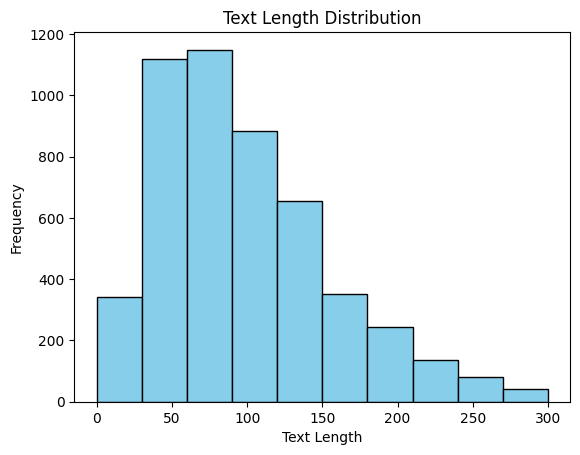

In [17]:
# Calculate text lengths
df['text_length'] = df['text'].apply(len)
bins = np.linspace(0, 300, 11)

# Visualize text length distribution
plt.hist(df['text_length'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [18]:
# Split into train/test/validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Optionally, split the training set further into train/validation
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

# Display the sizes of each split
print("\nData split sizes:")
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")



Data split sizes:
Train set: 3600
Validation set: 400
Test set: 1000


In [22]:
#izbrem random forest and bagging

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Labels (target variable)
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values



Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       289
           1       0.72      0.88      0.79       340
           2       0.74      0.54      0.62        80
           3       0.91      0.76      0.83       134
           4       0.82      0.73      0.77       117
           5       0.71      0.80      0.75        40

    accuracy                           0.79      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.79      0.79      0.78      1000

Accuracy: 0.785


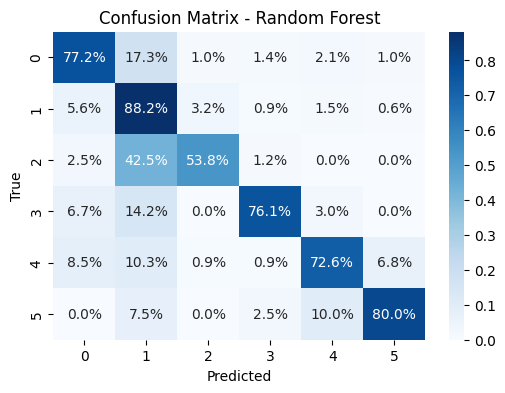

In [28]:
# Initialize and train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test set
rf_preds = rf_clf.predict(X_test)

# Evaluate Random Forest
print("Random Forest Classifier Performance:")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues', xticklabels=np.unique(df['label']), yticklabels=np.unique(df['label']))
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Bagging Classifier Performance:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       289
           1       0.85      0.88      0.87       340
           2       0.75      0.71      0.73        80
           3       0.90      0.90      0.90       134
           4       0.79      0.79      0.79       117
           5       0.71      0.80      0.75        40

    accuracy                           0.85      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.85      0.85      0.85      1000

Accuracy: 0.851


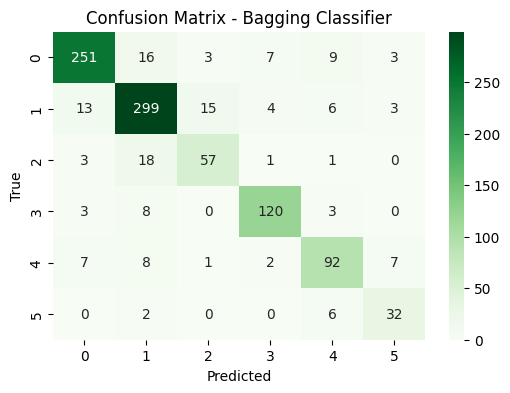

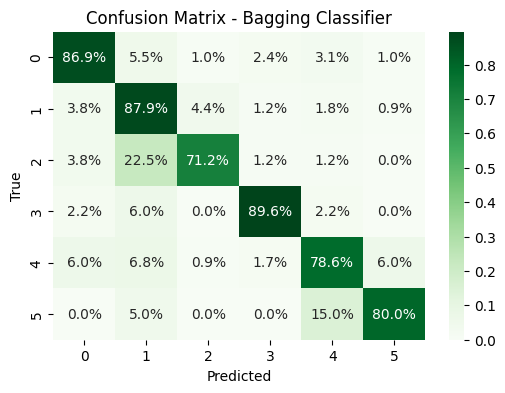

In [ ]:
# Initialize Bagging Classifier with Decision Trees as base learners
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, random_state=42),
    n_estimators=50,  # Number of base learners
    max_samples=0.8,  # Fraction of the training data sampled for each base learner
    random_state=42
)

# Train Bagging Classifier
bagging_clf.fit(X_train, y_train)

# Predict on test set
bagging_preds = bagging_clf.predict(X_test)

# Evaluate Bagging Classifier
print("Bagging Classifier Performance:")
print(classification_report(y_test, bagging_preds))
print("Accuracy:", accuracy_score(y_test, bagging_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, bagging_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(df['label']), yticklabels=np.unique(df['label']))
plt.title("Confusion Matrix - Bagging Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens', xticklabels=np.unique(df['label']), yticklabels=np.unique(df['label']))
plt.title("Confusion Matrix - Bagging Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

bagging_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.5, 0.8, 1.0]
}


# Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Grid Search for Bagging Classifier
bagging_grid_search = GridSearchCV(estimator=bagging_clf, param_grid=bagging_param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
bagging_grid_search.fit(X_train, y_train)

# Best models after hyperparameter tuning
best_rf_model = rf_grid_search.best_estimator_
best_bagging_model = bagging_grid_search.best_estimator_# Predict using the best models




In [37]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation for {model_name}:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-Score (macro):", f1_score(y_true, y_pred, average='macro'))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Evaluation for Random Forest (Optimized):
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       289
           1       0.72      0.88      0.79       340
           2       0.74      0.54      0.62        80
           3       0.91      0.76      0.83       134
           4       0.82      0.73      0.77       117
           5       0.71      0.80      0.75        40

    accuracy                           0.79      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.79      0.79      0.78      1000

Accuracy: 0.785
F1-Score (macro): 0.7623593978177216


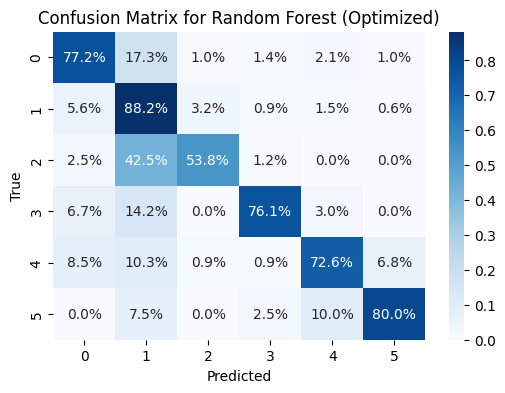

Evaluation for Bagging Classifier (Optimized):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       289
           1       0.88      0.87      0.87       340
           2       0.74      0.76      0.75        80
           3       0.90      0.87      0.89       134
           4       0.77      0.79      0.78       117
           5       0.72      0.82      0.77        40

    accuracy                           0.86      1000
   macro avg       0.82      0.83      0.83      1000
weighted avg       0.86      0.86      0.86      1000

Accuracy: 0.856
F1-Score (macro): 0.8258185994486391


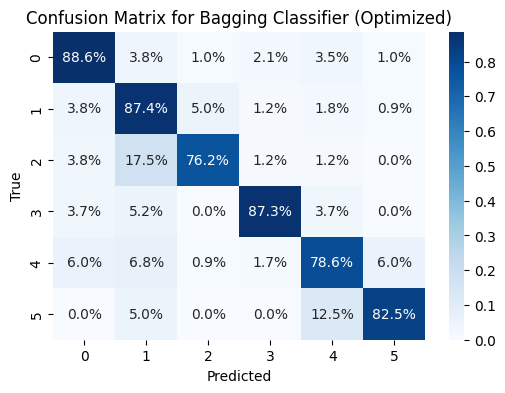

In [38]:
# Predict using the best models
rf_preds = best_rf_model.predict(X_test)
bagging_preds = best_bagging_model.predict(X_test)

# Evaluate the models using the custom evaluation function
evaluate_model(y_test, rf_preds, "Random Forest (Optimized)")
evaluate_model(y_test, bagging_preds, "Bagging Classifier (Optimized)")


In [39]:
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

print("Best parameters for Bagging Classifier:")
print(bagging_grid_search.best_params_)

Best parameters for Random Forest:
{'max_depth': None, 'n_estimators': 100}
Best parameters for Bagging Classifier:
{'max_samples': 1.0, 'n_estimators': 50}
